<a href="https://colab.research.google.com/github/harrisonxia/Predictive-Maintenance/blob/master/iot_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
uploaded = files.upload()

Saving part-00000-9bbc2c66-17ba-4260-964c-d4f40fd03234-c000.csv to part-00000-9bbc2c66-17ba-4260-964c-d4f40fd03234-c000.csv


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


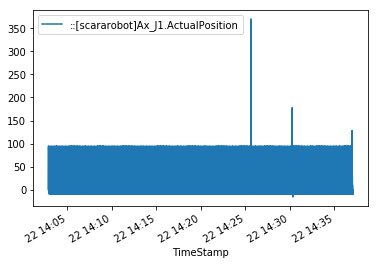

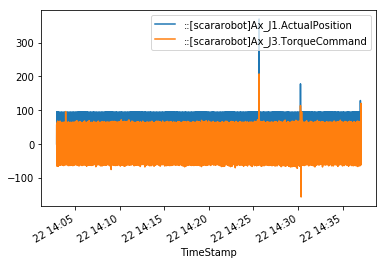

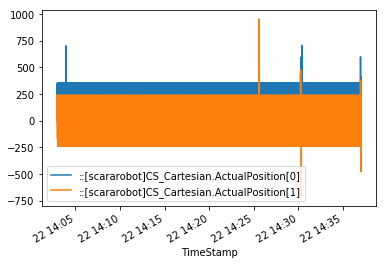

In [0]:
import io
import math
import pandas as pd
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt

df = pd.read_csv(io.BytesIO(uploaded['part-00000-9bbc2c66-17ba-4260-964c-d4f40fd03234-c000.csv'])).sort_values(
	 ['TimeStamp'], ascending = True).reset_index()

df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
  
df.drop(['::[scararobot]Ax_J1.PositionCommand','::[scararobot]Ax_J1.TorqueFeedback','::[scararobot]Ax_J2.PositionCommand','::[scararobot]Ax_J2.TorqueFeedback','::[scararobot]Ax_J3.TorqueFeedback','::[scararobot]Ax_J6.TorqueFeedback','::[scararobot]ScanTimeAverage','::[scararobot]Ax_J6.PositionCommand','::[scararobot]Ax_J3.PositionCommand','index'], axis=1, inplace=True)
  #df.iloc[:, 1 : 20] = df.iloc[:, 1: 20].abs()
df['Total']= df.select_dtypes(include=['float64','float32']).apply(lambda row: np.sum(row),axis=1)

df.plot(x="TimeStamp", y="::[scararobot]Ax_J1.ActualPosition", kind="line")
df.plot(x="TimeStamp", y=["::[scararobot]Ax_J1.ActualPosition","::[scararobot]Ax_J3.TorqueCommand"], kind="line")
df.plot(x="TimeStamp", y=["::[scararobot]CS_Cartesian.ActualPosition[0]","::[scararobot]CS_Cartesian.ActualPosition[1]"], kind="line")

[ 327.414406    0.        327.791445 ...    0.       -128.657941
    0.      ]
81900
819
(1, 100, 1)
[[[0.]]]
(1, 100, 1)
[[[4.029848]]]
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
0 	MSE: 43982.381927312665
100 	MSE: 27160.05537549583
200 	MSE: 20604.013589589773
300 	MSE: 16115.550750750035
400 	MSE: 12918.487837204477
500 	MSE: 10630.326053324987
600 	MSE: 8982.489187302148
700 	MSE: 7783.125079298161
800 	MSE: 6928.815771832875
900 	MSE: 6372.217196549408
1000 	MSE: 5928.236500005714
1100 	MSE: 5652.192318030235
1200 	MSE: 5568.9785418871925
1300 	MSE: 5556.861344320191
1400 	MSE: 5383.014397157042
1500 	MSE: 5279.038927683712
1600 	MSE: 5215.438236620198
1700 	MSE: 5156.669273862733
1800 	MSE: 5105.530138976755
1900 	MSE: 5071.1367561918505


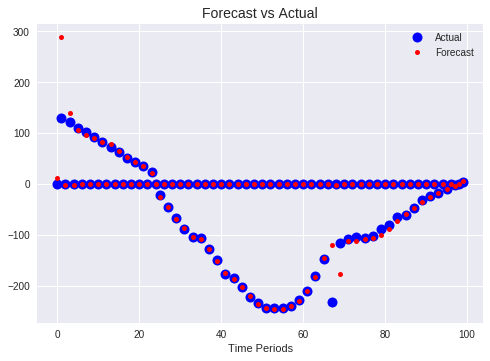

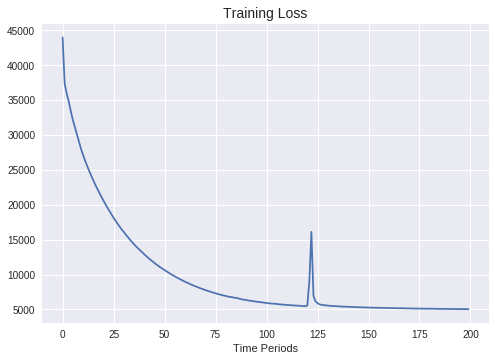

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


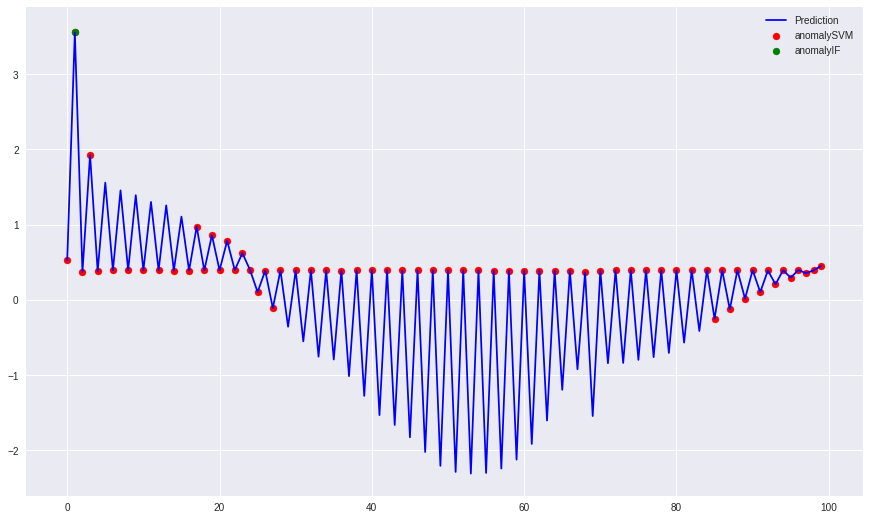

In [0]:
import io
import math
import pandas as pd
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
#from tensorflow.saved_model import tag_constants
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, chi2

def loadCSV():
  df = pd.read_csv(io.BytesIO(uploaded['part-00000-9bbc2c66-17ba-4260-964c-d4f40fd03234-c000.csv'])).sort_values(
	 ['TimeStamp'], ascending = True).reset_index()

  df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
  
  df.drop(['::[scararobot]Ax_J1.PositionCommand','::[scararobot]Ax_J1.TorqueFeedback','::[scararobot]Ax_J2.PositionCommand','::[scararobot]Ax_J2.TorqueFeedback','::[scararobot]Ax_J3.TorqueFeedback','::[scararobot]Ax_J6.TorqueFeedback','::[scararobot]ScanTimeAverage','::[scararobot]Ax_J6.PositionCommand','::[scararobot]Ax_J3.PositionCommand','index'], axis=1, inplace=True)
  #df.iloc[:, 1 : 20] = df.iloc[:, 1: 20].abs()
  df['Total']= df.select_dtypes(include=['float64','float32']).apply(lambda row: np.sum(row),axis=1)
  return pd.Series(df['Total'])

def featureSelect(df):
  x = df.iloc[0:, 1: 20].values
  y = df.iloc[0:, 20: 21].values.flatten()
  y = np.array(y).astype(int)
  
  SelBest = SelectKBest(chi2, k = 10)
  SelBest.fit_transform(x, y)
  choosed_features = list(SelBest.get_support())
  f_df = df.iloc[0:, 0: 1]
  for index, fea in enumerate(choosed_features):
    if fea == True:
      f_df[str(index)] = df.iloc[0:, index]
  
  f_df['Total'] = f_df.select_dtypes(include = ['float64', 'float32']).apply(lambda row: np.sum(row), axis = 1)
  tensor = pd.Series(f_df['Total'])
  return tensor

def prepareData(num_periods, f_horizon, TS, test_size = 1):
  #create our training input data set "X"
  x_data = TS[:(len(TS)-(len(TS) % num_periods))]
  x_batches = x_data.reshape(-1, num_periods, 1)

  #create our training output dataset "y"
  y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
  print (y_data)
  print (len(y_data))
  y_batches = y_data.reshape(-1, num_periods, 1)
  print (len(y_batches))
  
  #create our test X and y data
  test_x_setup = TS[-(num_periods * test_size + f_horizon):]
  testX = test_x_setup[:num_periods * test_size].reshape(-1, num_periods, 1)
  testY = TS[-(num_periods * test_size):].reshape(-1, num_periods, 1)
  print (testX.shape)
  print (testX[:,(num_periods-1):num_periods])
  print (testY.shape)
  print (testY[:,(num_periods-1):num_periods])
  return x_batches, y_batches, testX, testY

def RNN_LSTM(num_periods, input_size, hidden_number, output_size):
  
  X = tf.placeholder(tf.float32, [None, num_periods, input_size], name = "X")   #create variable objects
  Y = tf.placeholder(tf.float32, [None, num_periods, output_size], name = "Y")

  LSTM_cell_1 = tf.contrib.rnn.LSTMCell(num_units = hidden_number, activation = tf.nn.tanh)
  LSTM_cell_2 = tf.contrib.rnn.LSTMCell(num_units = 100)
  stacked_lstm_cell = tf.contrib.rnn.MultiRNNCell([LSTM_cell_1, LSTM_cell_2])
  lstm_output, states = tf.nn.dynamic_rnn(stacked_lstm_cell, X, dtype=tf.float32)               #choose dynamic over static
  
  stacked_rnn_output = tf.reshape(lstm_output, [-1, hidden_number])           #change the form into a tensor
  weight = tf.Variable(tf.random_normal([100, 1]))   
  bias = tf.Variable(tf.random_normal([1]))   
  stacked_outputs = tf.matmul(stacked_rnn_output, weight) + bias  
  #stacked_outputs = tf.layers.dense(stacked_rnn_output, output_size)        #specify the type of layer (dense)
  f_outputs = tf.reshape(stacked_outputs, [-1, num_periods, output_size])          #shape of results
  return f_outputs, X, Y

def Train(lr, train_op, cost, epochs, device, X, Y, x_batches, y_batches, X_test, f_outputs):
  init_g = tf.global_variables_initializer()
  loss = []
  with tf.device(device):
    with tf.Session() as session:
      session.run(init_g)
      for ep in range(epochs):
        session.run(train_op, feed_dict = {X: x_batches, Y: y_batches})
        if ep % 10 == 0:
          mse = cost.eval(session = session, feed_dict = {X: x_batches, Y: y_batches})
          mse = math.sqrt(mse)
          if ep % 100 == 0:
            print(ep, "\tMSE:", mse)
          loss.append(mse)
      y_pred = session.run(f_outputs, feed_dict = {X: X_test})
  return session, y_pred, loss

#Plot our test y data and our y-predicted forecast
def plotPred(y_pred, Y_test):
  plt.title("Forecast vs Actual", fontsize=14)
  plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
  plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
  plt.legend(loc="upper right")
  plt.xlabel("Time Periods")
  plt.show()
  return

def plotLoss(loss):
  plt.title("Training Loss", fontsize=14)
  plt.plot(loss)
  plt.xlabel("Time Periods")
  plt.show()
  return

#anomaly detection
def anomalyDetection(pred, outliers_fraction, model = 'SVM'):
  if model == 'SVM':
    m = OneClassSVM(nu=0.95 * outliers_fraction, kernel="rbf",gamma='scale')
  elif model == 'IF':
    m = IsolationForest(contamination = outliers_fraction)
  m.fit(pred)
  column = 'anomaly_' + model
  pred[column] = pd.Series(m.predict(pred))
  return pred.loc[pred[column] == -1, ['Prediction']] 

def plotAD(pred, SVM, IF):
  fig, ax = plt.subplots(figsize=(15,9))

  ax.plot(pred['Prediction'], color='blue', label = 'Prediction')
  ax.scatter(list(SVM.index.values), list(SVM.Prediction.values), color = 'red', label = 'anomalySVM')
  ax.scatter(list(IF.index.values), list(IF.Prediction.values), color = 'green', label = 'anomalyIF')
  plt.legend(loc = 'upper right')
  plt.show()
  return

if __name__ == '__main__':
  #tensor = featureSelect(loadCSV())
  tensor = loadCSV()
  num_periods = 100
  f_horizon = 1       #number of periods into the future we are forecasting
  TS = np.array(tensor)   #convert time series object to an array
  
  x_batches, y_batches, X_test, Y_test = prepareData(num_periods, f_horizon, TS)
  
  #set up model parameters
  tf.reset_default_graph()   #reset graph
  input_size = 1            #number of vectors submitted
  hidden_number = 100          #number of neurons
  output_size = 1            #number of output vectors

  f_outputs, X, Y = RNN_LSTM(num_periods, input_size, hidden_number, output_size)
  
  #set up training parameters
  learning_rate = 0.005   #learning rate
  cost = tf.reduce_sum(tf.square(f_outputs - Y), name = 'cost')    #define the cost function
  optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)          #gradient descent method
  train_op = optimizer.minimize(cost)          #train the result of the application of the cost_function                                 
  epochs = 2000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation
  
  session, y_pred, loss = Train(learning_rate, train_op, cost, epochs, '/device:GPU:0', X, Y, x_batches, y_batches, X_test, f_outputs)

  DIR="/usr/tmp/IoTModel"  #path where the model will be saved
  #tf.saved_model.simple_save(session, DIR,
  #                         inputs={"X": X},
  #                         outputs={"outputs": f_outputs})
  
  plotPred(y_pred, Y_test)
  plotLoss(loss)
  
  #prepare for anomaly detection
  pred = pd.DataFrame(np.ravel(y_pred), columns = ['Prediction'])
  scaler = StandardScaler()
  np_scaled = scaler.fit_transform(pred)
  pred = pd.DataFrame(np_scaled, columns = ['Prediction'])
  
  SVM = anomalyDetection(pred, 0.002)
  IF = anomalyDetection(pred, 0.01, 'IF')
  plotAD(pred, SVM, IF)

  
  
  

